In [ ]:
# Basic scientific stack
!pip install ase matplotlib numpy scipy pandas

# Optional: GPAW (can be heavy, try only if you want DFT)
!pip install gpaw

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 MB 9.8 MB/s eta 0:00:00
  Created wheel for gpaw: filename=gpaw-25.7.0-cp311-cp311-linux_x86_64.whl size=2844004 sha256=d87da6bd68fb6c4fee6b5497dac00b6c6b6dbe0fb98cc8bc4201c567e8e4c0c4
  Stored in directory: /root/.cache/pip/wheels/17/58/e5/a59f7a9aae1336389053dbaeff26f3bc052417560800378150
Successfully built gpaw


In [ ]:
# Install GPAW PAW datasets (about 100 MB)
!wget https://wiki.fysik.dtu.dk/gpaw-files/gpaw-setups-0.9.20000.tar.gz
!tar -xzf gpaw-setups-0.9.20000.tar.gz


--2025-08-19 14:07:04--  https://wiki.fysik.dtu.dk/gpaw-files/gpaw-setups-0.9.20000.tar.gz
Resolving wiki.fysik.dtu.dk (wiki.fysik.dtu.dk)... 130.225.86.27
Connecting to wiki.fysik.dtu.dk (wiki.fysik.dtu.dk)|130.225.86.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52648851 (50M) [application/x-gzip]
Saving to: ‘gpaw-setups-0.9.20000.tar.gz.2’

gpaw-setups-0.9.200 100%[===================>]  50.21M  11.1MB/s    in 4.5s    

2025-08-19 14:07:10 (11.1 MB/s) - ‘gpaw-setups-0.9.20000.tar.gz.2’ saved [52648851/52648851]



In [ ]:
import os
os.environ["GPAW_SETUP_PATH"] = "/content/gpaw-setups-0.9.20000"

In [ ]:
# --Imports --
import numpy as np
import matplotlib.pyplot as plt
from ase.build import bulk
from gpaw import GPAW, FermiDirac
from ase.units import kJ
from scipy.optimize import curve_fit

In [ ]:
# Birch-Murnaghan EOS
def birch_murnaghan(V, E0, B0, B0p, V0):
    return E0 + (9*V0*B0/16)*(((V0/V)**(2/3)-1)**3*B0p +
                               ((V0/V)**(2/3)-1)**2*(6-4*(V0/V)**(2/3)))

# -- EOS Calculation for Si --
a0 = 5.43  # initial guess lattice constant (Å)
strains = np.linspace(-0.08, 0.08, 7)  # compress/expand around a0

volumes, energies = [], []

for s in strains:
    a = a0 * (1+s)
    atoms = bulk("Si", "diamond", a=a)
    calc = GPAW(mode='pw', xc='PBE',
                kpts={'density': 3.5, 'gamma': True},
                occupations=FermiDirac(0.1),
                txt=None)   # suppress long output
    atoms.calc = calc
    e = atoms.get_potential_energy()
    v = atoms.get_volume()
    volumes.append(v)
    energies.append(e)

volumes, energies = np.array(volumes), np.array(energies)

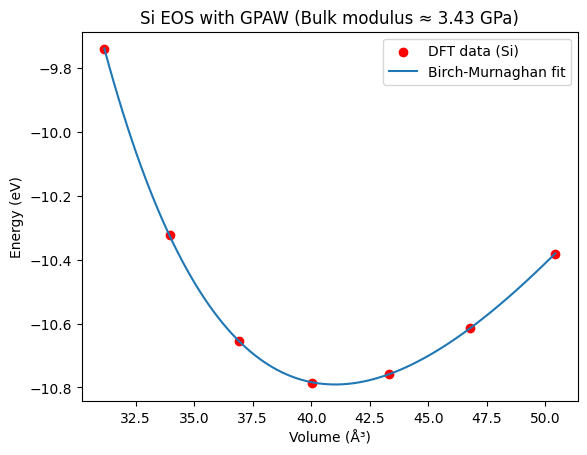

Fitted bulk modulus (GPa): 3.4254405282884584


In [ ]:
# -- Fit EOS --
popt, _ = curve_fit(birch_murnaghan, volumes, energies,
                    p0=[min(energies), 1.0, 4.0, volumes[np.argmin(energies)]])

E0, B0, B0p, V0 = popt
B0_GPa = B0 / (1e21 / kJ)  # convert to GPa

# --- STEP 6: Plot ---
Vfit = np.linspace(min(volumes), max(volumes), 100)
Efit = birch_murnaghan(Vfit, *popt)

plt.figure()
plt.scatter(volumes, energies, color="red", label="DFT data (Si)")
plt.plot(Vfit, Efit, label="Birch-Murnaghan fit")
plt.xlabel("Volume (Å³)")
plt.ylabel("Energy (eV)")
plt.legend()
plt.title(f"Si EOS with GPAW (Bulk modulus ≈ {B0_GPa:.2f} GPa)")
plt.show()

print("Fitted bulk modulus (GPa):", B0_GPa)